In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from keras.regularizers import l2
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.optimizers import Adam

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Detecção câncer de mama

### Importação

In [2]:
SELECTED_DATABASE = "mias"

try:
    breast_cancer_df = pd.read_csv(
        f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv"
    )
    aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_{SELECTED_DATABASE}.csv")
    breast_cancer_df = pd.concat([breast_cancer_df.drop(columns='pathology'), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

breast_cancer_df.head()

,dissimilarity_dist_1_ang_0,dissimilarity_dist_1_ang_45,dissimilarity_dist_1_ang_90,dissimilarity_dist_1_ang_135,correlation_dist_1_ang_0,correlation_dist_1_ang_45,correlation_dist_1_ang_90,correlation_dist_1_ang_135,homogeneity_dist_1_ang_0,homogeneity_dist_1_ang_45,...,contrast_dist_1_ang_135,energy_dist_1_ang_0,energy_dist_1_ang_45,energy_dist_1_ang_90,energy_dist_1_ang_135,ASM_dist_1_ang_0,ASM_dist_1_ang_45,ASM_dist_1_ang_90,ASM_dist_1_ang_135,pathology
0,4.625919,6.196418,5.005535,5.335784,0.986351,0.975721,0.984228,0.982162,0.248943,0.187090,...,52.560922,0.020599,0.017327,0.019312,0.018479,0.000424,0.000300,0.000373,0.000341,benign
1,3.868332,4.704555,3.893180,4.551105,0.987226,0.981210,0.986787,0.981845,0.310897,0.248718,...,40.583774,0.031036,0.026001,0.028314,0.026572,0.000963,0.000676,0.000802,0.000706,benign
2,2.808325,4.833903,3.721335,3.431363,0.974110,0.900932,0.938040,0.949139,0.365829,0.256144,...,37.676600,0.066008,0.053864,0.060593,0.063414,0.004357,0.002901,0.003672,0.004021,benign
3,2.808325,4.833903,3.721335,3.431363,0.974110,0.900932,0.938040,0.949139,0.365829,0.256144,...,37.676600,0.066008,0.053864,0.060593,0.063414,0.004357,0.002901,0.003672,0.004021,benign
4,4.324955,5.098914,4.809695,6.073281,0.967441,0.956665,0.959927,0.932232,0.323253,0.292527,...,100.520808,0.053347,0.049548,0.052149,0.047895,0.002846,0.002455,0.002720,0.002294,benign


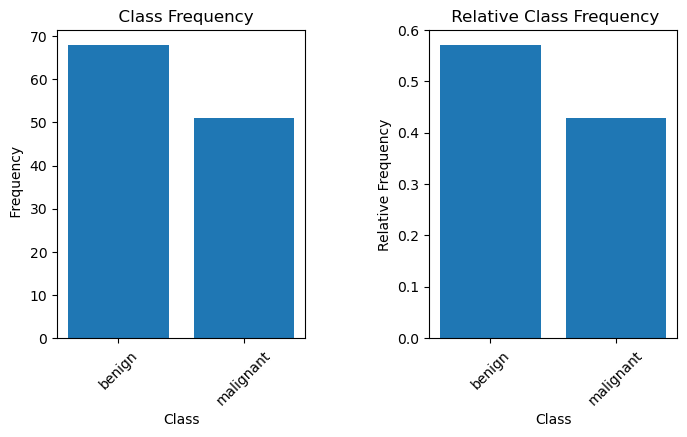

In [3]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [4]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
X_train.to_csv("../../tmp_data/X_train.csv")
X_test.to_csv("../../tmp_data/X_test.csv")

# Balanceamento dos dados
if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)
elif SELECTED_DATABASE in ["cmmd"]:
    random_under_sampler = RandomUnderSampler()
    X_train, y_train = random_under_sampler.fit_resample(X_train, y_train)

# Reduz a dimensionalidade
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Padroniza os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Treinamento dos modelos

In [5]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    _, axs = plt.subplots(1, 2, figsize=(10, 4))

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="valid accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="valid error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(25, input_dim=shape, activation="relu", kernel_regularizer=l2(0.1)))
    model.add(Dropout(0.5))
    # model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.1)))
    # model.add(Dropout(0.3))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.005), metrics=["accuracy"])
    return model

Random Forest:
Train Accuracy: 0.9881
Valid Accuracy: 0.5909

Gradient Boosting:
Train Accuracy: 0.9881
Valid Accuracy: 0.5455

1/1 [==============================] - 0s 13ms/step
MLP:
Train Accuracy: 0.7500
Valid Accuracy: 0.6818



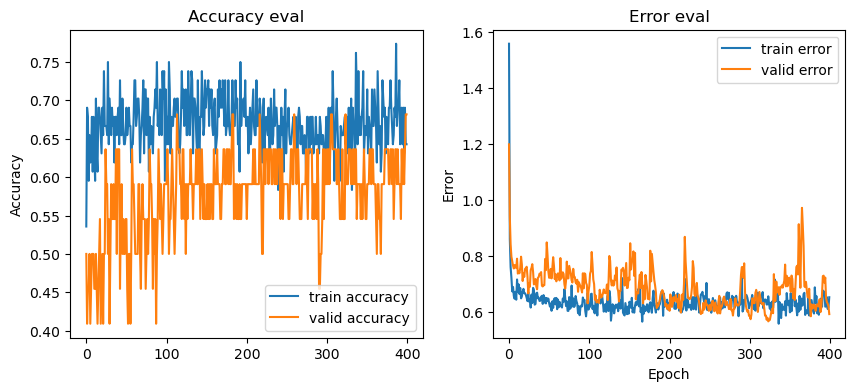

In [6]:
epochs = 400
batch_size = 1
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20)


random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                             criterion='entropy', max_depth=8,
                                             max_features='sqrt', n_estimators=70,
                                             min_samples_split=3, min_samples_leaf=2,
                                             n_jobs=-1)

gradient_boosting_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=8,
                                                     max_features='sqrt', n_estimators=60,
                                                     subsample=0.8, min_samples_split=3,
                                                     min_samples_leaf=2)

mlp_model = create_mlp_model(X_train.shape[1])

models = [random_forest_model, gradient_boosting_model]
titles = ['Random Forest', 'Gradient Boosting']

for model, title in zip(models, titles):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    print(
        f"{title}:\n"
        f"Train Accuracy: {train_accuracy:.4f}\n"
        f"Valid Accuracy: {valid_accuracy:.4f}\n"
    )

history = mlp_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        verbose=0, validation_data=(X_valid, y_valid))

y_train_pred = mlp_model.predict(X_train)
y_valid_pred = mlp_model.predict(X_valid)
y_train_pred = (y_train_pred > 0.5).astype(int)
y_valid_pred = (y_valid_pred > 0.5).astype(int)


train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)

print(
    f"MLP:\n"
    f"Train Accuracy: {train_accuracy:.4f}\n"
    f"Valid Accuracy: {valid_accuracy:.4f}\n"
)

plot_history(history)

In [7]:
""" # Models
random_forest_model = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                             criterion='entropy', max_depth=8,
                                             max_features='sqrt', n_estimators=70,
                                             min_samples_split=3, min_samples_leaf=2,
                                             n_jobs=-1)

gradient_boosting_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=8,
                                                     max_features='sqrt', n_estimators=60,
                                                     subsample=0.8, min_samples_split=3,
                                                     min_samples_leaf=2)

mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "Boosted Tree", "MLP"]
models = [random_forest_model, gradient_boosting_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100 """

' # Models\nrandom_forest_model = RandomForestClassifier(bootstrap=True, class_weight=\'balanced\',\n                                             criterion=\'entropy\', max_depth=8,\n                                             max_features=\'sqrt\', n_estimators=70,\n                                             min_samples_split=3, min_samples_leaf=2,\n                                             n_jobs=-1)\n\ngradient_boosting_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=8,\n                                                     max_features=\'sqrt\', n_estimators=60,\n                                                     subsample=0.8, min_samples_split=3,\n                                                     min_samples_leaf=2)\n\nmlp_model = create_mlp_model(X_train.shape[1])\n\nthreshold = 0.5\ntitles = ["Random Forest", "Boosted Tree", "MLP"]\nmodels = [random_forest_model, gradient_boosting_model, mlp_model]\nscores = {}\n\nfor model, title in zip(models, titles

### Avaliação dos modelos

In [8]:
""" scores_df = pd.DataFrame(scores).T
scores_df """

' scores_df = pd.DataFrame(scores).T\nscores_df '

In [9]:
""" result = [[66.66, 66.66, 66.66, 58.33], [50.00, 50.00, 54.16, 50.00], []]

columns=['Random Forest', 'Boosted Tree', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df """

" result = [[66.66, 66.66, 66.66, 58.33], [50.00, 50.00, 54.16, 50.00], []]\n\ncolumns=['Random Forest', 'Boosted Tree', 'MLP']\ndf = pd.DataFrame(result, columns=columns)\n\ndef mean_without_extremes(df):\n    new_df = pd.DataFrame(columns=df.columns)\n    for col in df.columns:\n        df.sort_values(by=col, inplace=True)\n        df[col] = df[col].drop(df[col].index[[0, -1]])\n        new_df[col] = [df[col].mean()]\n    return new_df\n\ndf = mean_without_extremes(df)\ndf "